In [1]:
from diff_predictor import data_process, predxgboost
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

Using current directory for loading/saving: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
To change current directory, call diff_predictor.core.change_dir(...)


In [2]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

In [3]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [4]:
age_dataset_path = workbookDir + '/data/raw_data_age/'
age_filelist = [f for f in listdir(age_dataset_path) if isfile(join(age_dataset_path, f)) and 'feat' in f]
print(len(age_filelist))

region_dataset_path = workbookDir + '/data/region_feature_folder/'
region_filelist = [f for f in listdir(region_dataset_path) if isfile(join(region_dataset_path, f)) and 'feat' in f]
print(len(region_filelist))

treatment_dataset_path = workbookDir + '/data/ecm_feature_folder/'
treatment_filelist = [f for f in listdir(treatment_dataset_path) if isfile(join(treatment_dataset_path, f)) and 'msd' in f]
print(len(treatment_filelist))

75
38
180


# Deep dive into Age Dataset

In [32]:
fstats_tot_age = data_process.generate_fullstats(age_dataset_path, age_filelist, ['P14','NT', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P70_40nm_s1_v1.csv size: (27, 67)
Adding file features_P70_40nm_s3_v4.csv size: (2909, 67)
Adding file features_P14_40nm_s1_v1.csv size: (793, 91)
Adding file features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file features_P70_40nm_s1_v3.csv size: 

In [33]:
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [34]:
ecm = fstats_tot_age[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [ ]:
ecm['alpha'].max()

## Here are the cutoffs for different motion types

### alpha > 1.25: Directed Motion
### 1.25 ≥ alpha ≥ 0.75: Normal Diffusion
### 0.75 > alpha: Anomalous Diffusion/Confined Diffusion

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


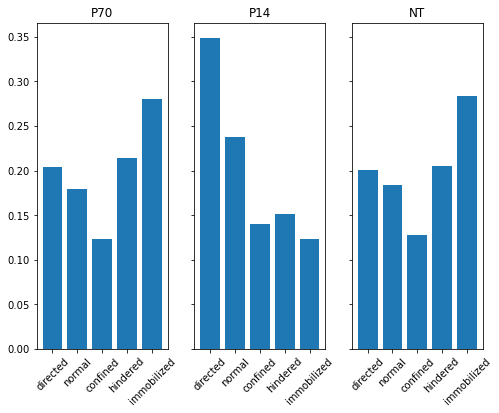

In [18]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['directed', 'normal', 'confined', 'hindered', 'immobilized']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.25]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[(df['alpha'] < 0.75) & (df['alpha'] > 0.5)]
    percentages.append(len(confined_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.2)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [ ]:
mx = np.array(p70_ecm['alpha'])
x = np.sort(mx)
y = np.arange(1, len(mx)+1) / len(mx)
x, y = ecdf(mx)

In [ ]:
from matplotlib.ticker import PercentFormatter
bin_num = 500
fig, ax = plt.subplots(1,3)
ax[0].hist(np.array(p14_ecm['alpha']), bins=bin_num)
ax[1].hist(np.array(p35_ecm['alpha']), bins=bin_num)
ax[2].hist(np.array(p70_ecm['alpha']), bins=bin_num)
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


In [ ]:
fig = plt.figure(figsize=(12,8))
for df in age_df_list:
    mx = np.array(df['alpha'])
    x = np.sort(mx)
    y = np.arange(1, len(mx)+1) / len(mx)
    plt.scatter(x, y, alpha=0.7, s=1, label=df['age'].unique()[0])
plt.vlines([directed], 0, 1, label='normal diffusion cutoff', linestyles='dashed')
plt.vlines(confined, 0, 1, label='confined diffusion cutoff', linestyles='dotted')
plt.xlim([0,3])
plt.legend()

In [35]:
# confined_ecm = ecm[ecm['alpha'] < 0.75]
# normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
# directed_ecm = ecm[ecm['alpha'] > 1.25]

# directed_normal_ecm = ecm[ecm['alpha'] >= 0.75]
# directed_confined_ecm = ecm[(ecm['alpha'] > 1.25) | (ecm['alpha'] < 0.75)]
# normal_confined_ecm = ecm[ecm['alpha'] <= 1.25]

# no_immobil = ecm[ecm['alpha'] > 0.2]

In [36]:
def full_preprocess(ecm, balanced=True, target=None):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        #sampled_df = bal_ecm.sample(frac=0.5)
        sampled_df = data_process.bin_data(bal_ecm)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df[target]
    features_df = sampled_df.drop([target, 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, y_test



In [45]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 5,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [38]:
confined_ecm = ecm[(ecm['alpha'] < 0.75) & (ecm['alpha'] > 0.5)]
normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
directed_ecm = ecm[ecm['alpha'] > 1.25]

hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
immobilized_ecm = ecm[ecm['alpha'] <= 0.2]

In [39]:
target = 'age'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
hindered_acc_list = []
immobilized_acc_list = []
#no_imm_acc = []
for i in range(100):
    print(i)
    # dtrain, dtest, dval, y_test= full_preprocess(normal_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # normal_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=800, verbose=False)
    directed_acc_list.append(acc)

    # dtrain, dtest, dval, y_test= full_preprocess(confined_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # confined_acc_list.append(acc)

    # dtrain, dtest, dval, y_test= full_preprocess(ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # all_acc_list.append(acc)

    # dtrain, dtest, dval, y_test= full_preprocess(hindered_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # hindered_acc_list.append(acc)

    # dtrain, dtest, dval, y_test= full_preprocess(immobilized_ecm, balanced=True, target=target)
    # booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    # immobilized_acc_list.append(acc)

0
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.841820987654321
1
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.8355945730247406
2
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.84140625
3
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707
Accuracy: 0.8416602613374328
4
Ratio before data balance (P70:P14:NT) = 2851:1707:2977
Ratio after balance (P70:P14:NT) = 1707:1707:1707


KeyboardInterrupt: 

In [36]:
age_dict = {'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(confined_acc_list),
                  'normal_acc': np.array(normal_acc_list),
                  'hindered_acc': np.array(hindered_acc_list),
                  'immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
age_result_df = pd.DataFrame.from_dict(age_dict)
age_result_df.to_csv('age_accuracies_v2.csv', index=False)

Text(0.5, 1.0, 'ECDF of Model Accuracy for different diffusion modes')

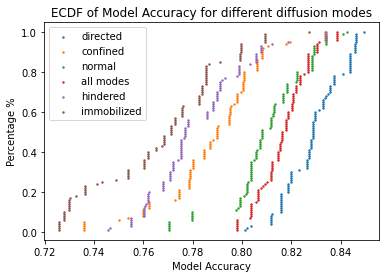

In [37]:
plt.figure()
conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
hind_x, hind_y = ecdf(np.array(hindered_acc_list))
imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
#no_imm_x, no_imm_y = ecdf(np.array(no_imm_acc))
plt.scatter(dir_x, dir_y, label='directed', s=2)
plt.scatter(conf_x, conf_y, label='confined', s=2)
plt.scatter(norm_x, norm_y, label='normal', s=2)
plt.scatter(all_x, all_y, label='all modes', s=2)
plt.scatter(hind_x, hind_y, label='hindered', s=2)
plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_imm_x, no_imm_y, label='no immobilized points', s=0.5)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
#plt.xlim([0.73, 0.86])

In [ ]:
plt.scatter(dir_x, dir_y, label='directed')

In [ ]:
directed_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(directed_ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

In [ ]:
all_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

In [ ]:
normal_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(normal_ecm, balanced=True)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

In [59]:
(best_model, best_param, best_eval, best_boost_rounds) = predxgboost.xgb_paramsearch(xtrain=dtrain, y)

NameError: name 'X_train' is not defined

# Deep dive into region data

In [40]:
fstats_tot_region = data_process.generate_fullstats(region_dataset_path, region_filelist, ['cortex', 'ganglia', 'hippocampus', 'thalamus', 'striatum'], 'region')

Adding file feat_NT_slice_2_striatum_vid_4.csv size: (10237, 67)
Adding file feat_NT_slice_2_striatum_vid_5.csv size: (13938, 67)
Adding file feat_NT_slice_1_striatum_vid_1.csv size: (2431, 67)
Adding file feat_NT_slice_2_cortex_vid_4.csv size: (1429, 67)
Adding file feat_NT_slice_1_striatum_vid_3.csv size: (1536, 67)
Adding file feat_NT_slice_1_cortex_vid_10.csv size: (4832, 67)
Adding file feat_NT_slice_1_striatum_vid_2.csv size: (2240, 67)
Adding file feat_NT_slice_2_cortex_vid_5.csv size: (2210, 67)
Adding file feat_NT_slice_2_cortex_vid_1.csv size: (1388, 67)
Adding file feat_NT_slice_2_hippocampus_vid_2.csv size: (46, 67)
Adding file feat_NT_slice_2_striatum_vid_2.csv size: (10500, 67)
Adding file feat_NT_slice_2_striatum_vid_3.csv size: (11355, 67)
Adding file feat_NT_slice_2_hippocampus_vid_3.csv size: (307, 67)
Adding file feat_NT_slice_2_cortex_vid_2.csv size: (1784, 67)
Adding file feat_NT_slice_1_cortex_vid_8.csv size: (1984, 67)
Adding file feat_NT_slice_1_striatum_vid_5.c

In [41]:
target = 'region'
ecm = fstats_tot_region[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(125416, 36)


(96085, 36)

In [85]:
hippo_ecm = ecm[ecm[target] == 'hippocampus']
thala_ecm = ecm[ecm[target] == 'thalamus']
gangl_ecm = ecm[ecm[target] == 'ganglia']
cortex_ecm = ecm[ecm[target] == 'cortex']
striat_ecm = ecm[ecm[target] == 'striatum']

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


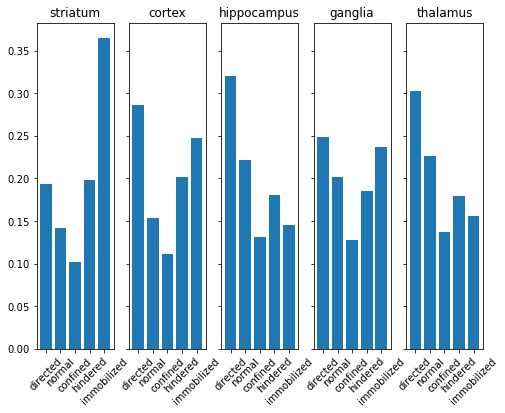

In [25]:
#age_df_list = [hippo_ecm, thala_ecm, gangl_ecm, cortex_ecm, striat_ecm]
fig, axes = plt.subplots(1,len(ecm[target].unique()), sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['directed', 'normal', 'confined', 'hindered', 'immobilized']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.25]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[(df['alpha'] < 0.75) & (df['alpha'] > 0.5)]
    percentages.append(len(confined_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.2)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [44]:
confined_ecm = ecm[(ecm['alpha'] < 0.75) & (ecm['alpha'] > 0.5)]
normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
directed_ecm = ecm[ecm['alpha'] > 1.25]

hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
immobilized_ecm = ecm[ecm['alpha'] <= 0.2]

best_ecm = ecm[(ecm['alpha'] > 1.25) | (ecm['alpha'] <= 0.2)]
len(best_ecm)

50660

In [ ]:
target = 'region'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
hindered_acc_list = []
immobilized_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(normal_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(confined_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    confined_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(hindered_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    hindered_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(immobilized_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    immobilized_acc_list.append(acc)

In [47]:
target = 'region'
best_ecm_acc = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(best_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    best_ecm_acc.append(acc)

0
Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 24642:14897:4692:1405:5024
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 1405:1405:1405:1405:1405
Accuracy: 0.578544061302682
1
Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 24642:14897:4692:1405:5024
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 1405:1405:1405:1405:1405
Accuracy: 0.5675675675675675
2
Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 24642:14897:4692:1405:5024
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 1405:1405:1405:1405:1405
Accuracy: 0.5645342312008979
3
Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 24642:14897:4692:1405:5024
Ratio after balance (striatum:cortex:hippocampus:ganglia:thalamus) = 1405:1405:1405:1405:1405
Accuracy: 0.5707209686296092
4
Ratio before data balance (striatum:cortex:hippocampus:ganglia:thalamus) = 24642:14897:4692

(0.5, 0.64)

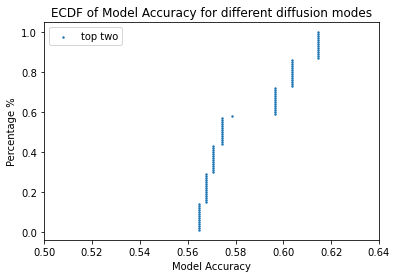

In [49]:
plt.figure()
# conf_x, conf_y = ecdf(np.array(confined_acc_list))
# dir_x, dir_y = ecdf(np.array(directed_acc_list))
# norm_x, norm_y = ecdf(np.array(normal_acc_list))
# all_x, all_y = ecdf(np.array(all_acc_list))
# hind_x, hind_y = ecdf(np.array(hindered_acc_list))
# imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
best_x, best_y = ecdf(np.array(best_ecm_acc))
#no_norm_x, no_norm_y = ecdf(np.array(no_normal_acc))
# plt.scatter(dir_x, dir_y, label='directed', s=2)
# plt.scatter(conf_x, conf_y, label='confined', s=2)
# plt.scatter(norm_x, norm_y, label='normal', s=2)
# plt.scatter(all_x, all_y, label='all modes', s=2)
# plt.scatter(hind_x, hind_y, label='hindered', s=2)
# plt.scatter(imm_x, imm_y, label='immobilized', s=2)
#plt.scatter(no_norm_x, no_norm_y, label='no normal points', s=0.5)
plt.scatter(best_x, best_y, label='top two', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')
plt.xlim([0.5, 0.64])

In [ ]:
plt.figure()
conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
hind_x, hind_y = ecdf(np.array(hindered_acc_list))
imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
plt.scatter(dir_x, dir_y, label='directed', s=2)
plt.scatter(conf_x, conf_y, label='confined', s=2)
plt.scatter(norm_x, norm_y, label='normal', s=2)
plt.scatter(all_x, all_y, label='all modes', s=2)
plt.scatter(hind_x, hind_y, label='hindered', s=2)
plt.scatter(imm_x, imm_y, label='immobilized', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')

In [137]:
region_dict = {'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(confined_acc_list),
                  'normal_acc': np.array(normal_acc_list),
                  'hindered_acc': np.array(hindered_acc_list),
                  'immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
region_result_df = pd.DataFrame.from_dict(treatment_dict)
region_result_df.to_csv('region_accuracies.csv', index=False)

# Deep dive into treatment data

In [26]:
fstats_tot_treatment = data_process.generate_fullstats(treatment_dataset_path, treatment_filelist, ['NT', 'ChABC'], 'treatment')

Adding file msd_ChABC_brain_3_slice_2_vid_4.csv size: (1240, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_2.csv size: (714, 67)
Adding file msd_NT_brain_4_slice_3_vid_5.csv size: (1876, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_4.csv size: (1594, 67)
Adding file msd_ChABC_brain_1_slice_3_vid_5.csv size: (1212, 67)
Adding file msd_NT_brain_4_slice_3_vid_4.csv size: (2106, 67)
Adding file msd_ChABC_brain_3_slice_2_vid_5.csv size: (2084, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_3.csv size: (1336, 67)
Adding file msd_NT_brain_2_slice_2_vid_1.csv size: (2488, 67)
Adding file msd_NT_brain_3_slice_2_vid_5.csv size: (893, 67)
Adding file msd_NT_brain_2_slice_2_vid_3.csv size: (1735, 67)
Adding file msd_ChABC_brain_2_slice_2_vid_1.csv size: (1788, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_4.csv size: (2689, 67)
Adding file msd_NT_brain_1_slice_3_vid_5.csv size: (1009, 67)
Adding file msd_NT_brain_1_slice_3_vid_4.csv size: (1446, 67)
Adding file msd_ChABC_brain_4_slice_3_vid_5.csv 

In [27]:
target = 'treatment'
ecm = fstats_tot_treatment[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(142453, 36)


(117505, 36)

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


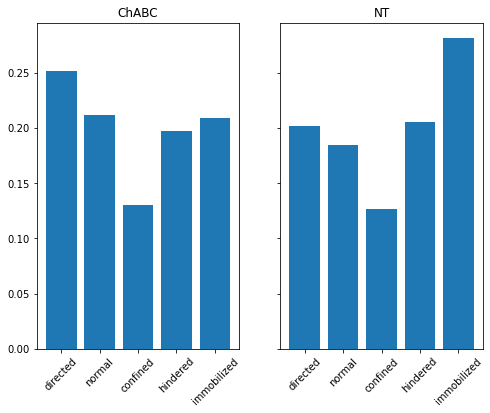

In [28]:
#age_df_list = [hippo_ecm, thala_ecm, gangl_ecm, cortex_ecm, striat_ecm]
fig, axes = plt.subplots(1,len(ecm[target].unique()), sharey=True, figsize=(8,6))
#plt.ylim([0, 250])


for i, unique_class in enumerate(ecm[target].unique()):
    labels = ['directed', 'normal', 'confined', 'hindered', 'immobilized']
    percentages = []
    #bins=200
    # print(f'class {unique_class}')
    df = ecm[ecm[target] == unique_class]

    directed_df = df[df['alpha'] > 1.25]
    percentages.append(len(directed_df)/len(df))
    # axes[i].hist(directed_df['alpha'], bins=bins)
    # print(len(directed_df))
    # print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    percentages.append(len(normal_df)/len(df))
    # axes[i].hist(normal_df['alpha'], bins=bins)
    # print(len(normal_df))
    # print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[(df['alpha'] < 0.75) & (df['alpha'] > 0.5)]
    percentages.append(len(confined_df)/len(df))
    # axes[i].hist(confined_df['alpha'], bins=bins)
    # print(len(confined_df))
    # print(f'confined diffusion %: {len(confined_df)/len(df)}')

    hindered_df = df[(df['alpha'] <= 0.5) & (df['alpha'] > 0.2)]
    percentages.append(len(hindered_df)/len(df))
    # axes[i].hist(hindered_df['alpha'], bins=bins)
    # print(f'hindered diffusion %: {len(hindered_df)/len(df)}')

    immobilized_df = df[(df['alpha'] <= 0.2)]
    percentages.append(len(immobilized_df)/len(df))
    # axes[i].hist(immobilized_df['alpha'], bins='doane')
    # print(f'immobilized diffusion %: {len(immobilized_df)/len(df)}')
    # print('')
    # axes[i].hist((df['alpha']), bins=40)
    #axes[i].vlines(([0.2, 0.5, 0.75, 1.25]), ymin=0, ymax=400, color='r')
    
    axes[i].bar(np.arange(len(percentages)), percentages)
    axes[i].set_xticklabels(labels)
    axes[i].set_xticks(np.arange(len(percentages)))
    axes[i].set_title(unique_class)

    #break

#for ax in axes:
    #ax.set_xscale('log')
    #ax.set_xlim([-1,1.4])

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [49]:
confined_ecm = ecm[(ecm['alpha'] < 0.75) & (ecm['alpha'] > 0.5)]
normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
directed_ecm = ecm[ecm['alpha'] > 1.25]

hindered_ecm = ecm[(ecm['alpha'] > 0.2) & (ecm['alpha'] <= 0.5)]
immobilized_ecm = ecm[ecm['alpha'] <= 0.2]

In [ ]:
target = 'treatment'

normal_acc_list = []
confined_acc_list = []
directed_acc_list = []
all_acc_list = []
hindered_acc_list = []
immobilized_acc_list = []
for i in range(100):
    print(i)
    dtrain, dtest, dval, y_test= full_preprocess(normal_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    normal_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(directed_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    directed_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(confined_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    confined_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    all_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(hindered_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    hindered_acc_list.append(acc)

    dtrain, dtest, dval, y_test= full_preprocess(immobilized_ecm, balanced=True, target=target)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    immobilized_acc_list.append(acc)

Text(0.5, 1.0, 'ECDF of Model Accuracy for different diffusion modes')

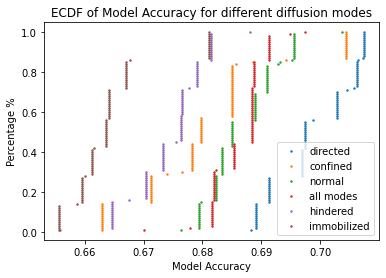

In [51]:
plt.figure()
conf_x, conf_y = ecdf(np.array(confined_acc_list))
dir_x, dir_y = ecdf(np.array(directed_acc_list))
norm_x, norm_y = ecdf(np.array(normal_acc_list))
all_x, all_y = ecdf(np.array(all_acc_list))
hind_x, hind_y = ecdf(np.array(hindered_acc_list))
imm_x, imm_y = ecdf(np.array(immobilized_acc_list))
plt.scatter(dir_x, dir_y, label='directed', s=2)
plt.scatter(conf_x, conf_y, label='confined', s=2)
plt.scatter(norm_x, norm_y, label='normal', s=2)
plt.scatter(all_x, all_y, label='all modes', s=2)
plt.scatter(hind_x, hind_y, label='hindered', s=2)
plt.scatter(imm_x, imm_y, label='immobilized', s=2)
plt.legend()
plt.xlabel('Model Accuracy')
plt.ylabel('Percentage %')
plt.title('ECDF of Model Accuracy for different diffusion modes')

In [52]:
treatment_dict = {'confined_acc': np.array(confined_acc_list),
                  'directed_acc': np.array(confined_acc_list),
                  'normal_acc': np.array(normal_acc_list),
                  'hindered_acc': np.array(hindered_acc_list),
                  'immobilized_acc': np.array(immobilized_acc_list),
                  'all_modes_acc': np.array(all_acc_list)
                    }
treatment_result_df = pd.DataFrame.from_dict(treatment_dict)
treatment_result_df.to_csv('treatment_accuracies_v2.csv', index=False)

,Unnamed: 0,confined_acc,directed_acc,normal_acc,hindered_acc,immobilized_acc,all_modes_acc
0,0,0.675711,0.675711,0.692193,0.682611,0.659446,0.684448
1,1,0.673444,0.673444,0.696599,0.673641,0.652695,0.686623
2,2,0.673938,0.673938,0.687854,0.675601,0.662781,0.687071
3,3,0.672334,0.672334,0.687091,0.682048,0.657193,0.675692
4,4,0.670672,0.670672,0.693346,0.688318,0.659500,0.682413
...,...,...,...,...,...,...,...
95,95,0.677995,0.677995,0.683330,0.688495,0.664064,0.688439
96,96,0.672614,0.672614,0.679475,0.688439,0.655722,0.685421
97,97,0.677479,0.677479,0.685098,0.685421,0.659595,0.688753
98,98,0.673415,0.673415,0.682276,0.688753,0.661239,0.691295
